In [1]:
import os
import sys
import platform
import settings

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['font.family'] = settings.FONT_FAMILY
plt.rcParams['font.size'] = settings.FONT_SIZE
plt.rcParams['figure.dpi'] = 300

from dataloader import DatasetGenerator, get_decathlon_filelist
from model import UNet2D, dice_coefficient, iou, sensitivity, specificity, hausdorff

print("Platform:              {}".format(platform.platform()))
print("Python version:        {}".format(sys.version))
print("TensorFlow version:    {}".format(tf.__version__))
gpu_status = "Available" if tf.config.list_physical_devices("GPU") else "Not Available"
color = "\033[92m" if gpu_status == "Available" else "\033[91m"
reset = "\033[0m"
print(f"GPU Status:            {color}{gpu_status}{reset}")

Platform:              macOS-15.1-arm64-arm-64bit
Python version:        3.10.8 (v3.10.8:aaaf517424, Oct 11 2022, 10:14:40) [Clang 13.0.0 (clang-1300.0.29.30)]
TensorFlow version:    2.15.0
GPU Status:            Available


In [2]:
saved_model_dir = os.path.join(settings.OUTPUT_PATH, settings.INFERENCE_FILENAME)
data_path = settings.TEST_DATA_PATH
crop_dim = settings.CROP_DIM
batch_size = settings.BATCH_SIZE
seed = settings.SEED
train_test_split = 1.0  # Use the entire BraTS2017 dataset for testing

In [3]:
testFiles, _, _ = get_decathlon_filelist(data_path=data_path, seed=seed, split=train_test_split)
ds_test = DatasetGenerator(testFiles,
                           batch_size=batch_size,
                           crop_dim=(crop_dim, crop_dim),
                           augment=False,
                           seed=seed,
                           dim=4
                           )

******************************
Dataset name:         BRATS
Dataset description:  Gliomas segmentation tumour and oedema in on brain images
Tensor image size:    4D
Dataset release:      2.0 04/05/2018
Dataset reference:    https://www.med.upenn.edu/sbia/brats2017.html
Dataset license:      CC-BY-SA 4.0
******************************
Number of training files   = 484
Number of validation files = 0
Number of testing files    = 0


In [4]:
model = keras.models.load_model(saved_model_dir, compile=True, custom_objects=UNet2D().custom_objects)

Data format = channels_last


2024-11-04 19:58:47.095036: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-04 19:58:47.095085: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-04 19:58:47.095092: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-04 19:58:47.095126: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-04 19:58:47.095142: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
metrics = model.evaluate(ds_test, verbose=0)
for idx, metric in enumerate(metrics):
    print("Test dataset {} = {:.4f}".format(model.metrics_names[idx], metric))

2024-11-04 19:58:48.571412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Test dataset loss = 0.2180
Test dataset dice_coefficient = 0.8005
Test dataset soft_dice_coefficient = 0.3858
Test dataset sensitivity = 0.8445
Test dataset specificity = 0.9936


In [6]:
metrics = {
    "Dice Coefficient": dice_coefficient,
    "Sensitivity": sensitivity,
    "Specificity": specificity,
}


def is_tumor_present(mask):
    return np.sum(mask) > 0


def calc_scores(ds, eval_model, eval_metric):
    all_slices, tumor_present, background_only = [], [], []

    for imgs, msks in ds:
        prediction = eval_model.predict(imgs, verbose=0)
        for i in range(len(imgs)):
            score = eval_metric(msks[i], prediction[i])
            all_slices.append(score)
            if is_tumor_present(msks[i]):
                tumor_present.append(score)
            else:
                background_only.append(score)

    return all_slices, tumor_present, background_only


def plot_histogram(all_scores, tumor_present_scores, background_only_scores, metric_name):
    plt.figure(figsize=(15, 5))

    def plot_with_stats(scores, subplot_index, title):
        plt.subplot(1, 3, subplot_index)
        plt.hist(scores, bins=10, range=(0, 1), density=True, alpha=0.7, color='darkorchid')
        plt.title(title)
        plt.xlabel(f'{metric_name}')
        plt.ylabel('Density')

        min_score = np.min(scores)
        max_score = np.max(scores)
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        stats_text = f'Min: {min_score:.2f}\nMax: {max_score:.2f}\nMean: {mean_score:.2f}\nStd: {std_score:.2f}'

        plt.text(0.05, 0.9, stats_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plot_with_stats(all_scores, 1, f'All')
    plot_with_stats(tumor_present_scores, 2, f'Tumor Present')
    plot_with_stats(background_only_scores, 3, f'Background Only')

    plt.suptitle(f'{metric_name} Scores', fontsize=20)
    plt.tight_layout()
    plt.show()

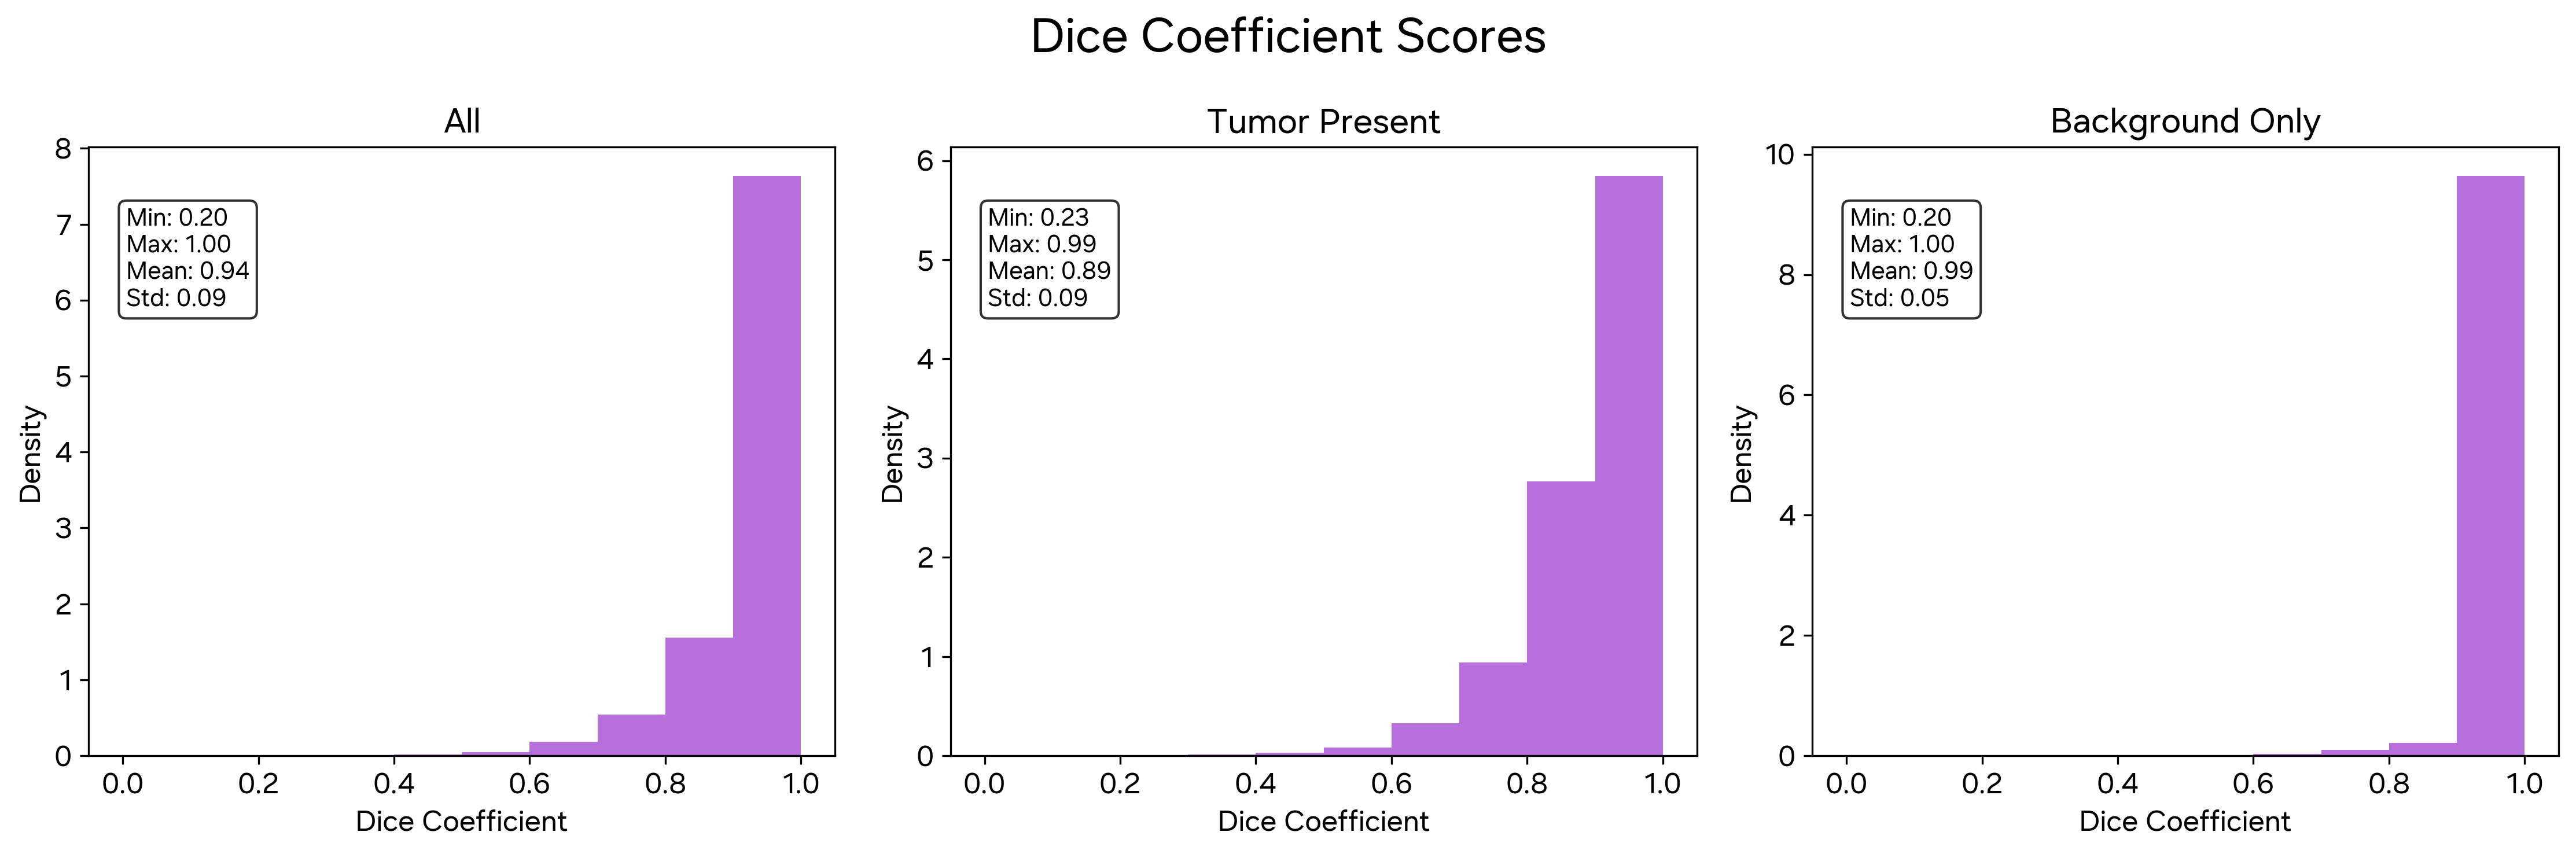

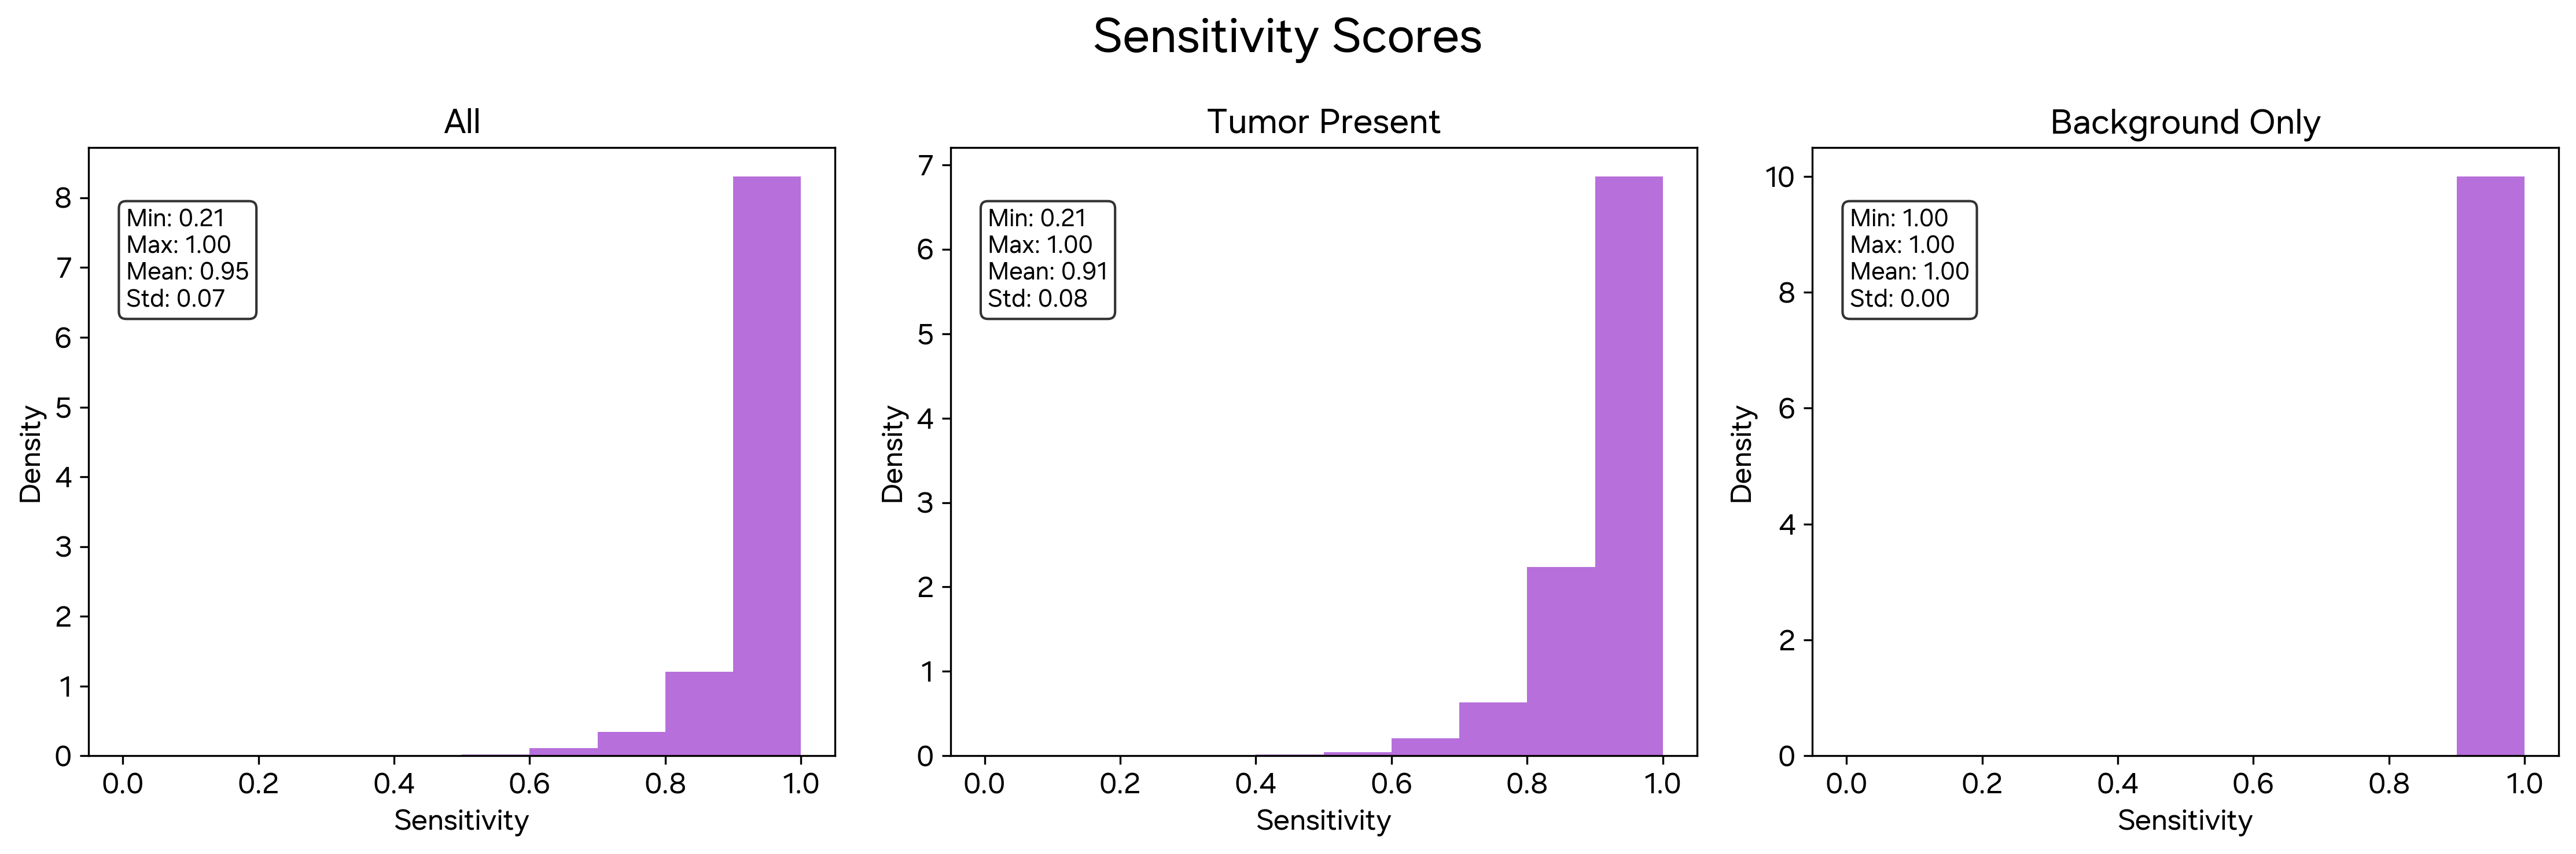

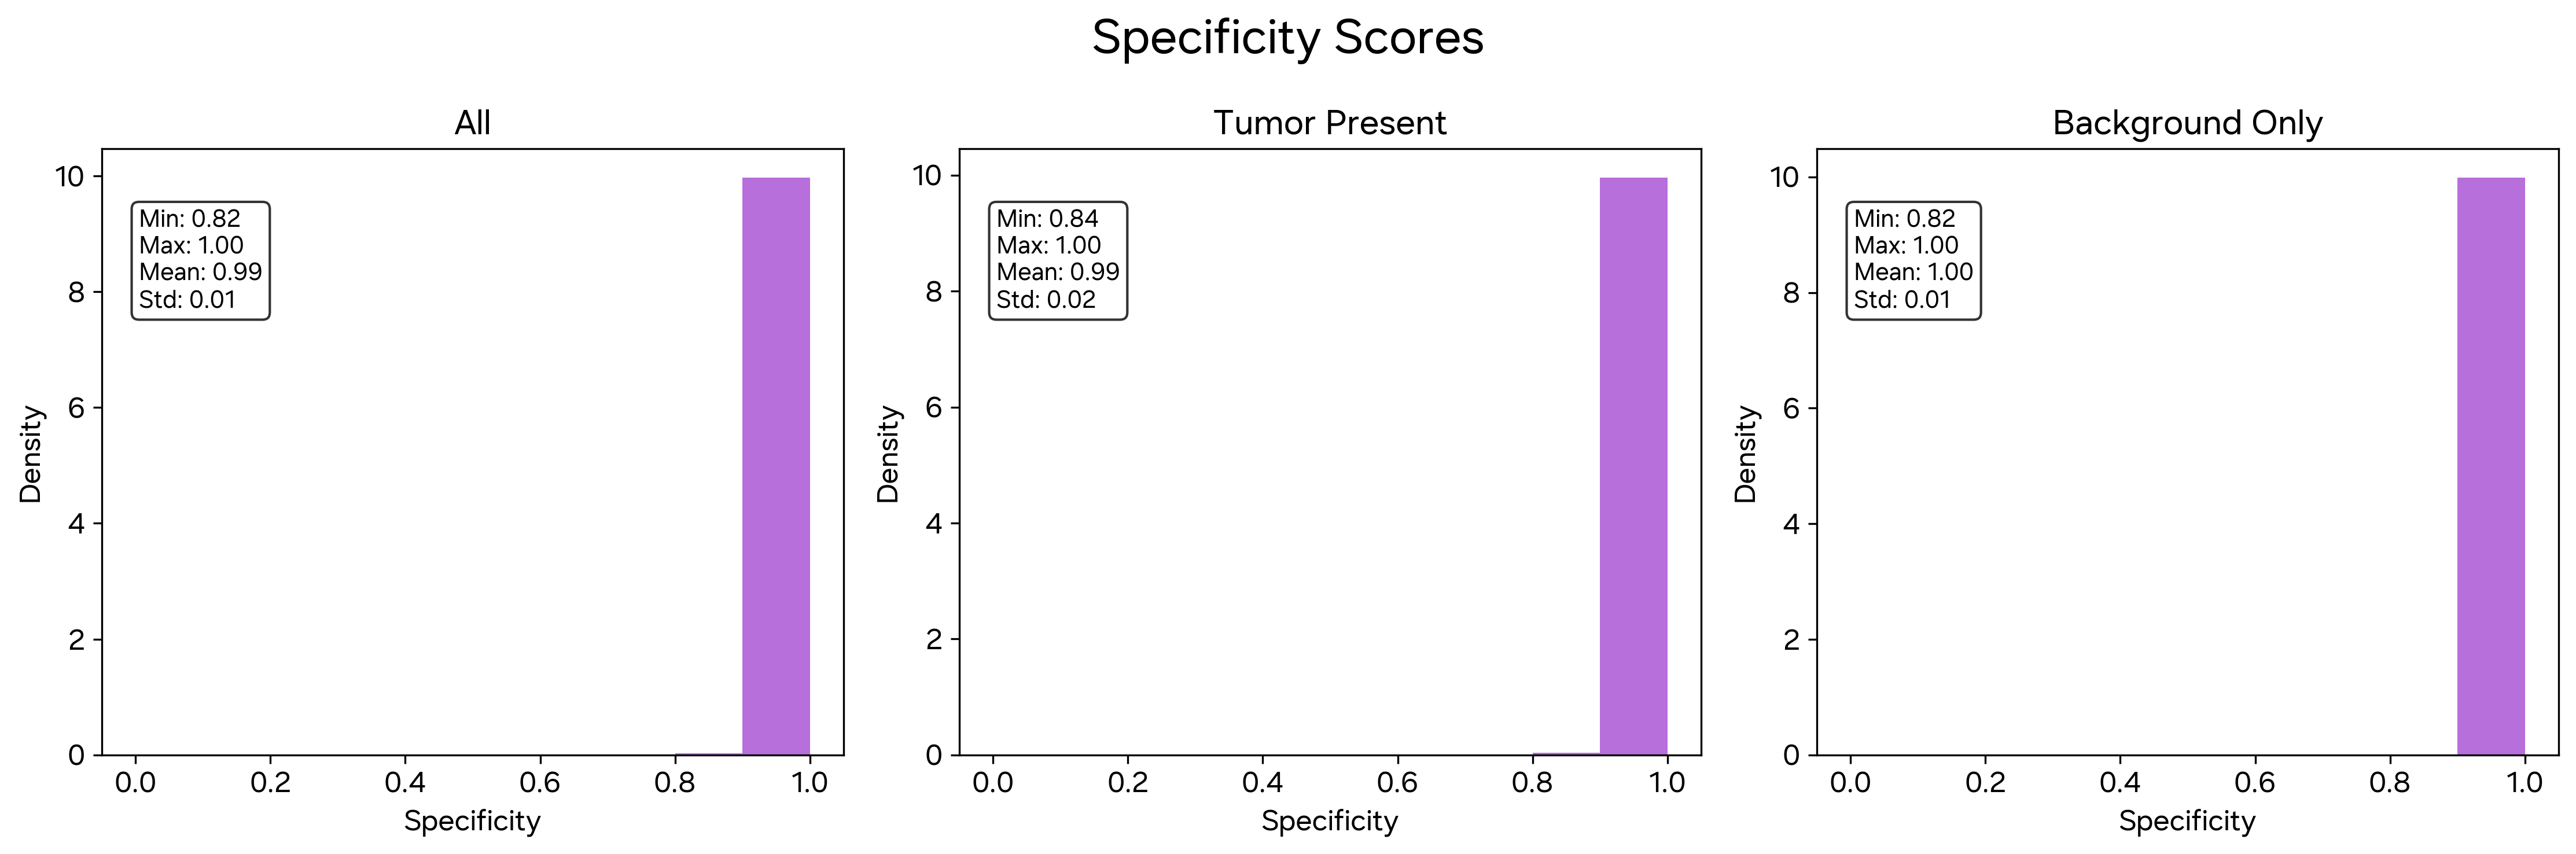

In [7]:
for name, metric in metrics.items():
    scores_arr = calc_scores(ds_test, model, metric)
    plot_histogram(scores_arr[0], scores_arr[1], scores_arr[2], name)